In [1]:
from typing import Any, Optional

import ase
import numpy
from ase.calculators.calculator import Calculator
from sella import Constraints, Internals, Sella


def sella_optimize(
    atms_obj: ase.Atoms,
    calc: Calculator,
    order: int = 0,
    ints_obj: Optional[Internals] = None,
    in_place: bool = False,
) -> ase.Atoms:
    """Optimize a geometry using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param order: 0 = minimum | 1 = saddle point
    :param ints_obj: A Sella Internals object, possibly involving constraints
    :param in_place: Modify the atoms object in place?
    """
    if not in_place:
        atms_obj = atms_obj.copy()

    atms_obj.calc = calc

    # Initialize and run the optimization
    dyn = Sella(
        atms_obj, order=order, internal=(True if ints_obj is None else ints_obj)
    )
    dyn.run()

    return atms_obj


def sella_optimize_minimum(
    atms_obj: ase.Atoms, calc: Calculator, in_place: bool = False
) -> ase.Atoms:
    """Optimize a minimum-energy structure using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param in_place: Modify the atoms object in place?
    """
    return sella_optimize(atms_obj, calc, order=0, in_place=in_place)


def sella_optimize_ts(
    atms_obj: ase.Atoms, calc: Calculator, in_place: bool = False
) -> ase.Atoms:
    """Optimize a TS/saddle-point structure using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param in_place: Modify the atoms object in place?
    """
    return sella_optimize(atms_obj, calc, order=1, in_place=in_place)


def sella_optimize_constrained(
    atms_obj: ase.Atoms,
    calc: Calculator,
    const_coos: Optional[list[tuple[int, ...]]] = None,
    in_place: bool = False,
) -> ase.Atoms:
    """Optimize a structure subject to internal coordinate constraints using Sella

    :param atms_obj: An ASE Atoms object
    :param calc: An ASE Calculator object
    :param const_coos: Optionally, constrain a set of coordinates
    :param in_place: Modify the atoms object in place?
    """
    if not in_place:
        atms_obj = atms_obj.copy()

    # Set up constraints
    const_obj = Constraints(atms_obj)
    for coo in const_coos:
        if len(coo) == 2:
            const_obj.fix_bond(coo)
        elif len(coo) == 3:
            const_obj.fix_angle(coo)
        elif len(coo) == 4:
            const_obj.fix_dihedral(coo)

    # Set up internal coordinates
    ints_obj = Internals(atms_obj, cons=const_obj)
    ints_obj.find_all_bonds()
    ints_obj.find_all_angles()
    ints_obj.find_all_dihedrals()

    # Note: For whatever reason, the Atoms object must be identical to the one passed in
    # to Constraints and Internals, so we *must* set in_place=True here
    return sella_optimize(atms_obj, calc, ints_obj=ints_obj, in_place=True)

In [2]:
import automol


def scan_relaxed(
    geo,
    calc: Calculator,
    scan_coos: Optional[list[tuple[int, ...]]] = None,
    scan_grids: Optional[list[numpy.ndarray]] = None,
    const_coos: Optional[list[tuple[int, ...]]] = None,
    gra: Optional[Any] = None,
) -> tuple[numpy.ndarray, numpy.ndarray]:
    """Perform a relaxed scan with constraints using Sella

    :param geo: An AutoMol molecular geometry data structure
    :param calc: An ASE Calculator object
    :param scan_coos: The set of coordinates to scan over
    :param scan_grids: The grids of coordinate values for the scan
    :param const_coos: Optionally, constrain a set of coordinates
    :param gra: The molecular graph, for setting coordinate values
    :return: The geometries and energies, as arrays over the scan grid
    """
    all_const_coos = list(scan_coos) + list(const_coos)

    shape = numpy.shape(scan_grids[0])
    geo_grid = numpy.empty(shape, dtype=numpy.object_)
    ene_grid = numpy.empty(shape, dtype=numpy.float_)

    for idx in numpy.ndindex(shape):
        for coo, grid in zip(scan_coos, scan_grids):
            assert len(coo) == 2, "For now, only allowing bond coordinate scans"
            geo = automol.geom.set_distance(geo, coo, grid[idx], gra=gra, angstrom=True)

        atms_obj0 = automol.geom.ase_atoms(geo)
        atms_obj = sella_optimize_constrained(atms_obj0, calc, const_coos=all_const_coos)
        geo = automol.geom.from_ase_atoms(atms_obj)

        geo_grid[idx] = geo
        ene_grid[idx] = atms_obj.get_total_energy()

    return geo_grid, ene_grid

In [16]:
from scipy import interpolate


def scan_saddle_point_index(scan_grids, ene_grid) -> tuple[int, ...]:
    """Determine the index of the saddle point from the scan data"""
    assert len(scan_grids) == 1, "2D scans not yet implemented"

    (scan_grid,) = scan_grids
    srt_idxs = numpy.argsort(scan_grid)
    x_points = scan_grid[srt_idxs]
    y_points = ene_grid[srt_idxs]

    # Check for delta sign changes to find the roots
    deltas = numpy.diff(y_points, append=y_points[-1])
    signs = numpy.sign(deltas)
    (root_idxs,) = numpy.where(numpy.diff(signs))
    print(root_idxs)

    saddle_idx = None
    for root_idx in root_idxs:
        neg_before = numpy.all(deltas[root_idx - 1 : root_idx + 1] > 0.0)
        pos_after = numpy.all(deltas[root_idx + 1 : root_idx + 3] < 0.0)
        if neg_before and pos_after:
            saddle_idx = root_idx

    return saddle_idx

In [4]:
from tblite.ase import TBLite

calc = TBLite(method="GFN1-xTB", verbosity=0)

# 0. Define the reaction by SMILES
rsmi, psmi = ("CCCO[O]", "[CH2]CCOO")
# rsmi, psmi = ("CCC[CH2]", "CC[CH]C")
rsmis = automol.smiles.split(rsmi)
psmis = automol.smiles.split(psmi)

# 1. Find minimum energy geometries for the reactants
ratms_objs = list(map(automol.geom.ase_atoms, map(automol.smiles.geometry, rsmis)))
ratms_objs = [sella_optimize_minimum(o, calc=calc) for o in ratms_objs]
rgeos = list(map(automol.geom.from_ase_atoms, ratms_objs))

# 2. Map the reaction
rxn, *_ = automol.reac.from_smiles(rsmis, psmis, stereo=False)

# 3. Generate a TS guess structure
rxn = automol.reac.with_structures(rxn, "geom", rct_strucs=rgeos)
ts_gra = automol.reac.ts_graph(rxn)
geo0 = automol.reac.ts_structure(rxn)
scan_coos = automol.reac.scan_coordinates(rxn)
scan_vals = automol.reac.scan_values(rxn)
scan_grids = numpy.meshgrid(*scan_vals)
const_coos = automol.reac.constraint_coordinates(rxn)

# 4. Do a relaxed scan over the reaction coordinate
geo_grid, ene_grid = scan_relaxed(
    geo=geo0,
    calc=calc,
    scan_coos=scan_coos,
    scan_grids=scan_grids,
    const_coos=const_coos,
    gra=ts_gra,
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/avcopan/code/amech-dev/src/autochem/sella-repo/notebook-examples/.pixi/envs/default/lib/python3.12/site-packages/ase/optimize/optimize.py:372: FutureWarning: force_consistent keyword is deprecated and will be ignored.  This will raise an error in future versions of ASE.
  warnings.warn(


     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 18:03:00     -525.805458       1.3084       0.0000       0.1000       1.0000
Sella   1 18:03:03     -525.903020       0.3646       0.0000       0.1000       1.0946
Sella   2 18:03:04     -525.915607       0.2396       0.0000       0.1000       1.3557
Sella   3 18:03:05     -525.920654       0.1239       0.0000       0.1000       0.9202
Sella   4 18:03:06     -525.921163       0.0491       0.0000       0.1000       1.2178


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/home/avcopan/code/amech-dev/src/autochem/sella-repo/notebook-examples/.pixi/envs/default/lib/python3.12/site-packages/ase/optimize/optimize.py:372: FutureWarning: force_consistent keyword is deprecated and will be ignored.  This will raise an error in future versions of ASE.
  warnings.warn(


     Step     Time          Energy         fmax         cmax       rtrust          rho
Sella   0 18:03:13     -523.901807       7.5976       0.0000       0.1000       1.0000
Sella   1 18:03:15     -524.731295       3.0608       0.0001       0.1150       1.0251
Sella   2 18:03:16     -524.991353       1.9133       0.0004       0.1150       1.1487
Sella   3 18:03:18     -525.156352       1.3285       0.0004       0.1322       1.0202
Sella   4 18:03:20     -525.292944       0.8596       0.0004       0.1521       1.0184
Sella   5 18:03:22     -525.418772       0.5524       0.0004       0.1749       1.0167
Sella   6 18:03:24     -525.539468       0.3652       0.0002       0.2011       1.0246
Sella   7 18:03:26     -525.650621       0.2198       0.0002       0.2011       1.0389
Sella   8 18:03:28     -525.725450       0.1934       0.0007       0.2011       1.0558
Sella   9 18:03:29     -525.757074       0.1514       0.0007       0.2011       1.0883
Sella  10 18:03:31     -525.766114       0.

[ 4 13 14]
4


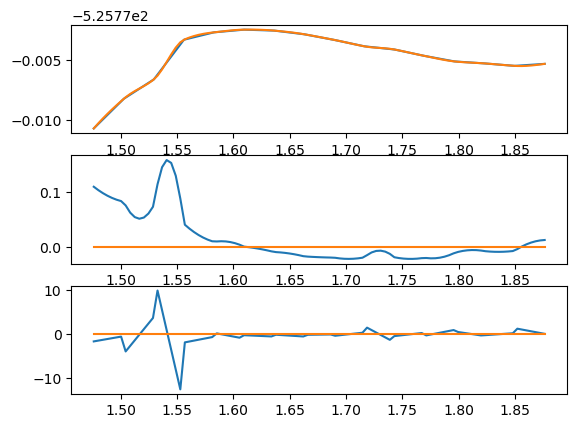

In [17]:
from matplotlib import pyplot

print(scan_saddle_point_index(scan_grids, ene_grid))

scan_grid, = scan_grids
srt_idxs = numpy.argsort(scan_grid)
x_points = scan_grid[srt_idxs]
y_points = ene_grid[srt_idxs]

y = interpolate.Akima1DInterpolator(x_points, y_points)
x = numpy.linspace(numpy.min(*scan_grids), numpy.max(*scan_grids), 100)

fig, ax = pyplot.subplots(3)
ax[0].plot(*scan_grids, ene_grid)
ax[0].plot(x, y(x))
ax[1].plot(x, y(x, nu=1))
ax[1].plot(x, numpy.zeros_like(x))
ax[2].plot(x, y(x, nu=2))
ax[2].plot(x, numpy.zeros_like(x))
pyplot.show()

In [ ]:
# Visualize the results
def log_geometry_info(geo, scan_coos, const_coos, gra=None):
    """Print and display information about a geometry

    :param geo: An automol geometry data structure
    :param coo: The reaction/scan coordinate
    :param const_coos: Any constrained coordinates
    """
    # Display the geometry
    automol.geom.display(geo, gra=gra)

    # Print distances for the scan coordinates
    print("Scan coordinates:")
    for coo in scan_coos:
        dist = automol.geom.distance(geo, *coo, angstrom=True)
        print(f" - {coo} distance: {dist}")

    # Print distances for the constraint coordinates
    print("Constraint coordinates:")
    for coo in const_coos:
        dist = automol.geom.distance(geo, *coo, angstrom=True)
        print(f" - {coo} distance: {dist}")


automol.graph.display(ts_gra, label=True, exp=True)

print("\nStarting geometry:")
log_geometry_info(geo0, scan_coos, const_coos, gra=ts_gra)

print("\nScan geometries:")
for idx in numpy.ndindex(numpy.shape(ene_grid)):
    ene = ene_grid[idx]
    geo = geo_grid[idx]
    log_geometry_info(geo, scan_coos, const_coos, gra=ts_gra)
    print("Energy:", ene)
    print("*** ***\n")


Starting geometry:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.826187202853765
Constraint coordinates:
 - (3, 4) distance: 1.4342032722935716

Scan geometries:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.876187273833863
Constraint coordinates:
 - (3, 4) distance: 1.4342027365456078
Energy: -525.7753121506266
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.8495225659881904
Constraint coordinates:
 - (3, 4) distance: 1.434200965628275
Energy: -525.7754794109482
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.8228539433226276
Constraint coordinates:
 - (3, 4) distance: 1.4342004928617316
Energy: -525.7752741988551
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.7961885487251932
Constraint coordinates:
 - (3, 4) distance: 1.4341994899273782
Energy: -525.7751071347107
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.76952061756792
Constraint coordinates:
 - (3, 4) distance: 1.4341991289223135
Energy: -525.7746411777204
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.7428540061457776
Constraint coordinates:
 - (3, 4) distance: 1.434198615522627
Energy: -525.7741036027633
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.7161881364573612
Constraint coordinates:
 - (3, 4) distance: 1.434199489828449
Energy: -525.773835439491
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.6895205356408152
Constraint coordinates:
 - (3, 4) distance: 1.4341994966523863
Energy: -525.7732980575347
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.6628539222972631
Constraint coordinates:
 - (3, 4) distance: 1.4341995257205125
Energy: -525.77282306461
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.6361873209792526
Constraint coordinates:
 - (3, 4) distance: 1.4341997172867473
Energy: -525.7725148005726
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.6095206794763959
Constraint coordinates:
 - (3, 4) distance: 1.4342001680356715
Energy: -525.7724353542427
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.5828540018774935
Constraint coordinates:
 - (3, 4) distance: 1.4342009423610433
Energy: -525.772661234528
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.5561872994772046
Constraint coordinates:
 - (3, 4) distance: 1.4342020781835207
Energy: -525.7732823937973
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.5295182776932803
Constraint coordinates:
 - (3, 4) distance: 1.4342027310655536
Energy: -525.7766173856343
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.502853759763657
Constraint coordinates:
 - (3, 4) distance: 1.4342074374260458
Energy: -525.7782473911543
*** ***



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Scan coordinates:
 - (4, 5) distance: 1.4761874792448635
Constraint coordinates:
 - (3, 4) distance: 1.4342071210391547
Energy: -525.780742986241
*** ***

